In [226]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from constants import numeric_features, categorical_features
from sklearn.linear_model import LogisticRegression
from part2.shared import load_processed_data
from part2.shared import load_train_with_validation_data


In [227]:
NUMBER_OF_EPOCHS = 250

In [228]:

df = load_processed_data()
df = df[df["Target"].isin(["Graduate", "Dropout"])]
df["y"] = (df["Target"] == "Graduate").astype(int)
df = df.drop(columns=["Target", "Target encoded"], errors='ignore')

In [229]:
X = df.drop(columns=["y"])
y = df["y"].values

In [230]:
num_features = [c for c in numeric_features if c in X.columns]
cat_features = [c for c in categorical_features if c in X.columns]

In [231]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [232]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [233]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [234]:
X_train_raw, X_val_raw, X_test_raw, y_train, y_val, y_test = load_train_with_validation_data(X, y)
X_train = full_pipeline.fit_transform(X_train_raw)
X_test = full_pipeline.transform(X_test_raw)
X_val = full_pipeline.transform(X_val_raw)

In [235]:
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train.toarray()])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test.toarray()])
X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val.toarray()])

In [255]:
from part3.Logistic import CustomLogisticRegression
effective_l2 = 1 / (1000 * X_train.shape[0])

models = {
    "no_reg": CustomLogisticRegression(lr=0.05, epochs=250, batch_size=64, l1=0.0, l2=0.0, verbose=True),
    "l2_reg": CustomLogisticRegression(lr=0.05, epochs=250, batch_size=64, l1=0.0, l2=effective_l2, verbose=True),
    "l1_reg": CustomLogisticRegression(lr=0.05, epochs=250, batch_size=64, l1=0.0001, l2=0.0, verbose=True),
}

X_train = full_pipeline.fit_transform(X_train_raw)
X_val = full_pipeline.transform(X_val_raw)
X_test = full_pipeline.transform(X_test_raw)

X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train.toarray()])
X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val.toarray()])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test.toarray()])

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train_bias, y_train, X_val_bias, y_val, X_test_bias, y_test)



Training model: no_reg
Epoch   1/250  train_loss=0.4188  val_loss=0.3999
Epoch  20/250  train_loss=0.2548  val_loss=0.2455
Epoch  40/250  train_loss=0.2374  val_loss=0.2294
Epoch  60/250  train_loss=0.2302  val_loss=0.2226
Epoch  80/250  train_loss=0.2261  val_loss=0.2185
Epoch 100/250  train_loss=0.2235  val_loss=0.2155
Epoch 120/250  train_loss=0.2219  val_loss=0.2136
Epoch 140/250  train_loss=0.2206  val_loss=0.2128
Epoch 160/250  train_loss=0.2196  val_loss=0.2116
Epoch 180/250  train_loss=0.2188  val_loss=0.2109
Epoch 200/250  train_loss=0.2182  val_loss=0.2104
Epoch 220/250  train_loss=0.2178  val_loss=0.2099
Epoch 240/250  train_loss=0.2174  val_loss=0.2101

Training model: l2_reg
Epoch   1/250  train_loss=0.4188  val_loss=0.3999
Epoch  20/250  train_loss=0.2548  val_loss=0.2456
Epoch  40/250  train_loss=0.2374  val_loss=0.2294
Epoch  60/250  train_loss=0.2302  val_loss=0.2226
Epoch  80/250  train_loss=0.2261  val_loss=0.2186
Epoch 100/250  train_loss=0.2236  val_loss=0.2155
Ep

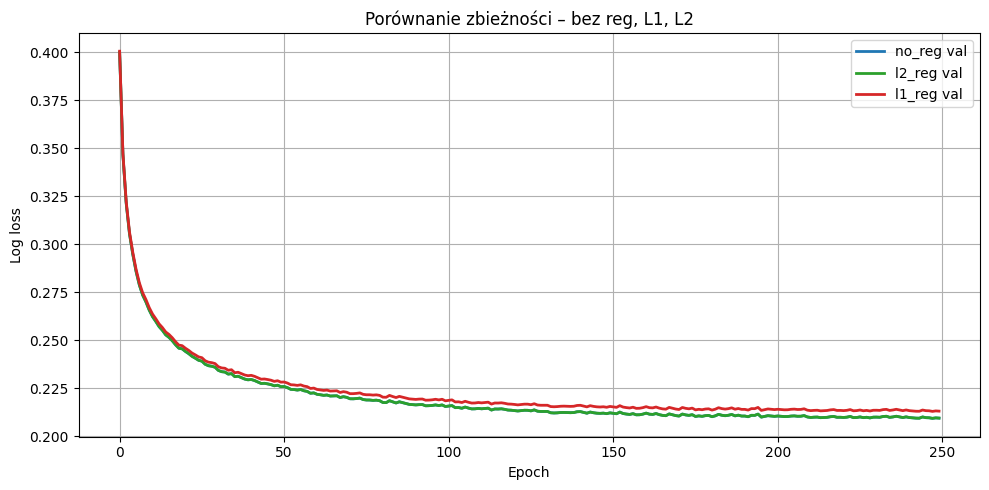

In [257]:
from matplotlib import pyplot as plt

colors = {
    "no_reg": "tab:blue",
    "l2_reg": "tab:green",
    "l1_reg": "tab:red"
}

plt.figure(figsize=(10, 5))

for name, model in models.items():
    plt.plot(model.history["val"], label=f"{name} val", color=colors[name], linewidth=2)

plt.title("Porównanie zbieżności – bez reg, L1, L2")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


sk_none: train_loss=0.2137, val_loss=0.2118
sk_l2: train_loss=0.2068, val_loss=0.2227
sk_l1: train_loss=0.2066, val_loss=0.2263


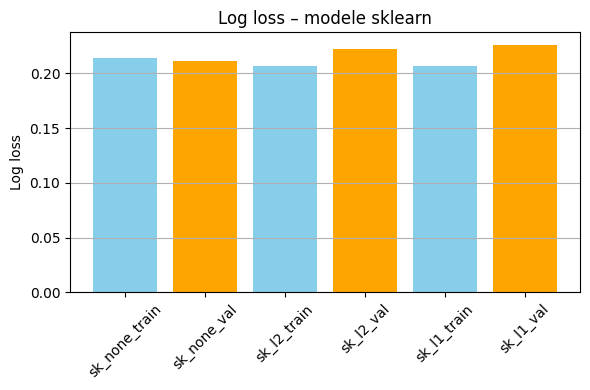

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
import matplotlib.pyplot as plt
import numpy as np

models_sklearn = {
    "sk_none": LogisticRegression(max_iter=250),
    "sk_l2": LogisticRegression(penalty="l2", C=1000, solver="lbfgs", max_iter=250),
    "sk_l1": LogisticRegression(penalty="l1", C=1000, solver="liblinear", max_iter=250),
}

# fit models and record log_loss
sklearn_hist = {}
for name, clf in models_sklearn.items():
    clf.fit(X_train_bias, y_train)
    pred_train = clf.predict_proba(X_train_bias)[:, 1]
    pred_val = clf.predict_proba(X_val_bias)[:, 1]
    loss_train = log_loss(y_train, pred_train)
    loss_val = log_loss(y_val, pred_val)
    sklearn_hist[name] = {"train": loss_train, "val": loss_val}

# wyświetlenie wyników
for name in sklearn_hist:
    print(f"{name}: train_loss={sklearn_hist[name]['train']:.4f}, val_loss={sklearn_hist[name]['val']:.4f}")

# wykres
plt.figure(figsize=(6, 4))
for name, result in sklearn_hist.items():
    plt.bar(name + "_train", result["train"], color="skyblue")
    plt.bar(name + "_val", result["val"], color="orange")

plt.title("Log loss – modele sklearn")
plt.ylabel("Log loss")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


In [258]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

comparison = {
    "Model": [],
    "Accuracy": [],
    "F1 (class 0)": [],
    "Recall (class 0)": []
}

for name, model in models.items():
    y_pred = model.predict(X_test_bias)
    comparison["Model"].append(name)
    comparison["Accuracy"].append(accuracy_score(y_test, y_pred))
    comparison["F1 (class 0)"].append(f1_score(y_test, y_pred, pos_label=0))
    comparison["Recall (class 0)"].append(recall_score(y_test, y_pred, pos_label=0))

import pandas as pd

df_comparison = pd.DataFrame(comparison)
print(df_comparison)


    Model  Accuracy  F1 (class 0)  Recall (class 0)
0  no_reg  0.914718      0.887681          0.862676
1  l2_reg  0.914718      0.887681          0.862676
2  l1_reg  0.914718      0.887681          0.862676


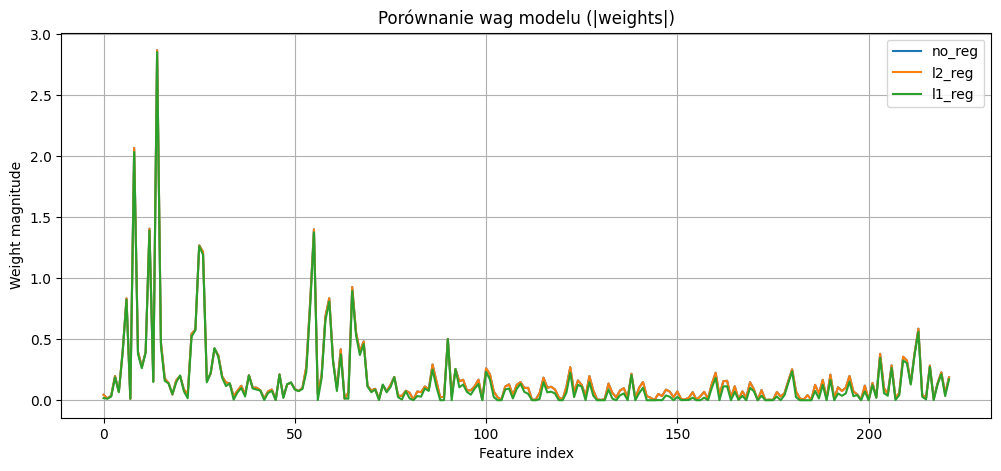

In [259]:
w_df = pd.DataFrame({
    "no_reg": models["no_reg"].w_,
    "l2_reg": models["l2_reg"].w_,
    "l1_reg": models["l1_reg"].w_,
})

# Wartości bezwzględne (łatwiej porównać)
w_df_abs = w_df.abs()
w_df_abs.plot(figsize=(12, 5), title="Porównanie wag modelu (|weights|)")
plt.xlabel("Feature index")
plt.ylabel("Weight magnitude")
plt.grid(True)
plt.show()
